# Use your own data and complete the following steps. Complete the assignment within a .ipynb notebook.

## Submit a .zip file containing your data and the results. Refer to demo_03-classification for examples of setting up a custom dataset.

# * Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
data_dir = pathlib.Path('/Users/hims/.keras/datasets/hw3/')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

300


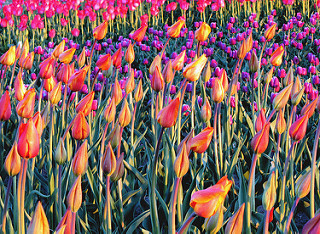

In [4]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

# * Step 2. Split this data between 80% training and 20% test


In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 240 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'sunflowers', 'tulips']


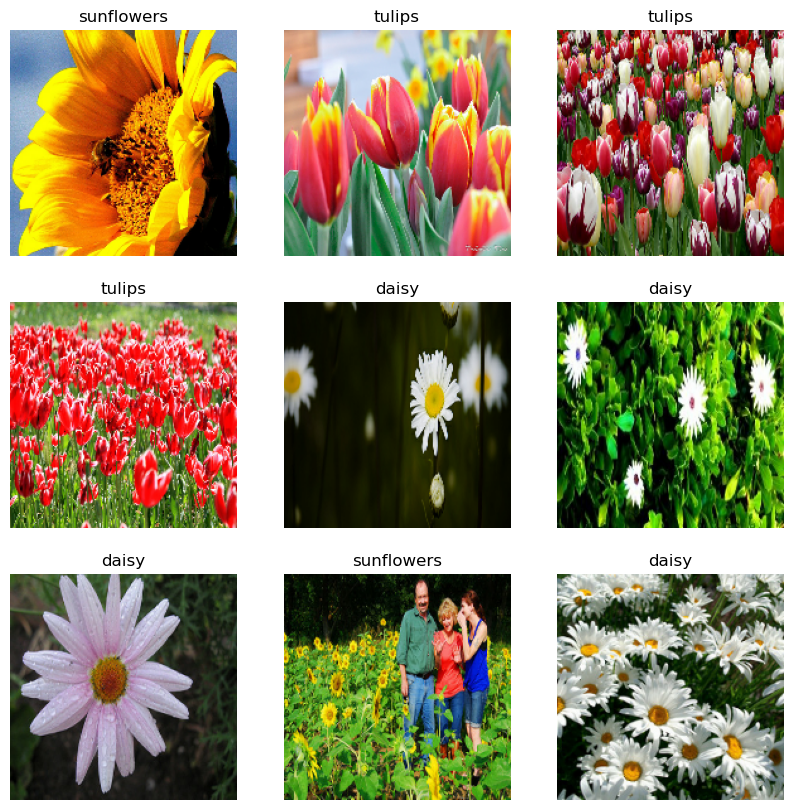

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# * Step 3. Preprocess the data as you see fit


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# * Step 4. Create a Convolutional Neural Network model to learn about your training set


In [12]:
def train(model, train_ds, epochs):
    history = model.fit(
      train_ds,
#       validation_data=val_ds,
      epochs=epochs
    )
    return model, history

In [13]:
num_classes = 5

base_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
base_model

In [14]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
base_model, base_history = train(base_model, train_ds, epochs=10)

Epoch 1/10
8/8 [==============================] - 1s 148ms/step - loss: 1.8678 - accuracy: 0.2958 - val_loss: 1.1132 - val_accuracy: 0.4167
Epoch 2/10
8/8 [==============================] - 1s 135ms/step - loss: 1.0665 - accuracy: 0.4292 - val_loss: 1.0594 - val_accuracy: 0.5000
Epoch 3/10
8/8 [==============================] - 1s 137ms/step - loss: 0.8725 - accuracy: 0.6000 - val_loss: 0.9153 - val_accuracy: 0.5500
Epoch 4/10
8/8 [==============================] - 1s 133ms/step - loss: 0.6488 - accuracy: 0.7542 - val_loss: 0.7439 - val_accuracy: 0.7167
Epoch 5/10
8/8 [==============================] - 1s 134ms/step - loss: 0.5114 - accuracy: 0.7833 - val_loss: 0.7670 - val_accuracy: 0.6500
Epoch 6/10
8/8 [==============================] - 1s 134ms/step - loss: 0.3494 - accuracy: 0.8958 - val_loss: 0.7611 - val_accuracy: 0.7000
Epoch 7/10
8/8 [==============================] - 1s 134ms/step - loss: 0.2656 - accuracy: 0.9333 - val_loss: 0.7123 - val_accuracy: 0.7000
Epoch 8/10
8/8 [====

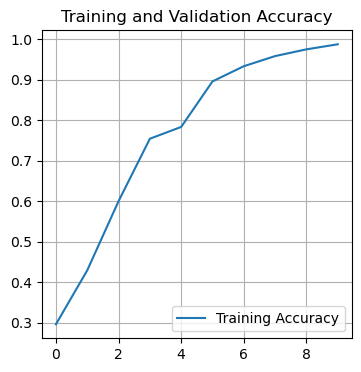

In [37]:
def plot_training_accuracy(history):
    acc = base_history.history['accuracy']
    epochs_range = range(len(acc))
    plt.figure(figsize=(4, 4))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

plot_training_accuracy(base_history)

# * Step 5. Make predictions on the test data and compare them to the expected categories


In [22]:
def evaluate(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
    return test_loss, test_accuracy*100

In [23]:
base_test_loss, base_test_accuracy = evaluate(base_model, val_ds)
print(f"{base_test_loss = }, {base_test_accuracy=}")

2/2 [==============================] - 0s 37ms/step - loss: 0.8631 - accuracy: 0.6833
base_test_loss = 0.8630840182304382, base_test_accuracy=68.33333373069763


# * Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 2: Load Pre-trained GoogleNet
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, 
                                               input_shape=(img_height, img_width, 3))

# Step 3: Add Custom Linear Layer
flatten_layer = layers.Flatten()(base_model.output)
dense_layer = layers.Dense(256, activation='relu')(flatten_layer)
output_layer = layers.Dense(3, activation='softmax')(dense_layer)

new_model = models.Model(inputs=base_model.input, outputs=output_layer)

# Step 4: Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False



# * Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [25]:
new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 89, 89, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 89, 89, 32)           96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 89, 89, 32)           0         ['batch_normalization[0][0

 conv2d_14 (Conv2D)          (None, 20, 20, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 20, 20, 64)           192       ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 20, 20, 64)           192       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 20, 20, 96)           288       ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 20, 20, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 20, 20, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 20, 20, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_31 (Conv2D)          (None, 20, 20, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 20, 20, 96)           288       ['conv2d_31[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 20, 20, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 9, 9, 384)            995328    ['mixed2[0][0]']              
          

 conv2d_33 (Conv2D)          (None, 9, 9, 192)            147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_36 (Conv2D)          (None, 9, 9, 192)            172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_41 (Conv2D)          (None, 9, 9, 192)            172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_42 (Conv2D)          (None, 9, 9, 192)            147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 9, 9, 192)            576       ['conv2d_33[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 9, 9, 768)            0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_43 (Conv2D)          (None, 9, 9, 192)            147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_46 (Conv2D)          (None, 9, 9, 192)            215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_51 (Conv2D)          (None, 9, 9, 192)            215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 9, 9, 160)            0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 9, 9, 160)            0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 9, 9, 768)            0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_53

 batch_normalization_62 (Ba  (None, 9, 9, 192)            576       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 9, 9, 192)            576       ['conv2d_70[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 9, 9, 192)            0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 9, 9, 192)            0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_74 (Conv2D)          (None, 4, 4, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_78 (Conv2D)          (None, 4, 4, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 4, 4, 320)            960       ['conv2d_74[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 4, 4, 192)            576       ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 4, 4, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 4, 4, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 4, 4, 192)            576       ['conv2d_87[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 4, 4, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 4, 4, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 4, 4, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [30]:
new_model, new_history = train(new_model, train_ds, epochs)

Epoch 1/10
8/8 [==============================] - 3s 432ms/step - loss: 1.0525 - accuracy: 0.9458 - val_loss: 35.6636 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 3s 430ms/step - loss: 0.5088 - accuracy: 0.9625 - val_loss: 41.2141 - val_accuracy: 0.5000
Epoch 3/10
8/8 [==============================] - 3s 431ms/step - loss: 0.2534 - accuracy: 0.9792 - val_loss: 37.0240 - val_accuracy: 0.5000
Epoch 4/10
8/8 [==============================] - 3s 429ms/step - loss: 0.0435 - accuracy: 0.9958 - val_loss: 37.0524 - val_accuracy: 0.5500
Epoch 5/10
8/8 [==============================] - 3s 427ms/step - loss: 0.0092 - accuracy: 0.9958 - val_loss: 35.2743 - val_accuracy: 0.5000
Epoch 6/10
8/8 [==============================] - 3s 431ms/step - loss: 0.0077 - accuracy: 0.9958 - val_loss: 42.4835 - val_accuracy: 0.5000
Epoch 7/10
8/8 [==============================] - 3s 466ms/step - loss: 0.0209 - accuracy: 0.9958 - val_loss: 39.5255 - val_accuracy: 0.5667
Epoch 8/10
8/

In [31]:
new_test_loss, new_test_accuracy = evaluate(new_model, val_ds)
print(f"{new_test_loss = }, {new_test_accuracy=}")

2/2 [==============================] - 1s 316ms/step - loss: 40.0204 - accuracy: 0.5167
new_test_loss = 40.02039337158203, new_test_accuracy=51.66666507720947


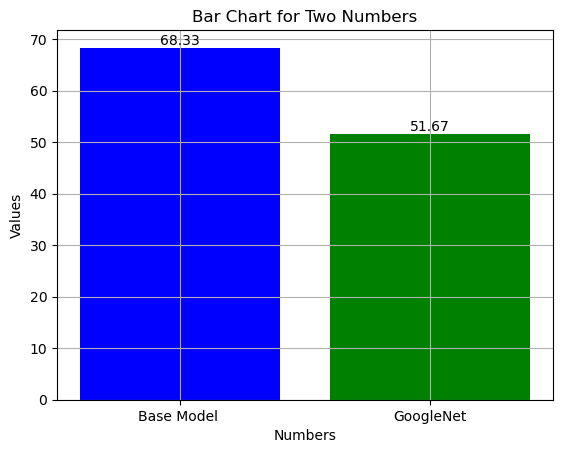

In [35]:
# Data
labels = ['Base Model ', 'GoogleNet']
values = [base_test_accuracy, new_test_accuracy]

# Plotting the bar chart
bars = plt.bar(labels, values, color=['blue', 'green'])
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(f'{value:.2f}'),
             ha='center', va='bottom')
plt.title('Bar Chart for Two Numbers')
plt.xlabel('Numbers')
plt.ylabel('Values')
plt.grid(True)
plt.show()